# Taxi Benchmark - Final Analysis

Comprehensive analysis comparing LP, MinMaxCostFlow, MAPS, and LinUCB methods across PL and Sigmoid acceptance functions.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import io
import json
from pathlib import Path
from typing import Dict, List, Optional

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create output directories
PLOTS_DIR = Path('plots_final')
TABLES_DIR = Path('tables_final')
PLOTS_DIR.mkdir(exist_ok=True)
TABLES_DIR.mkdir(exist_ok=True)

# Initialize S3 client
s3 = boto3.client('s3', region_name='eu-north-1')
BUCKET = 'taxi-benchmark'


## Configuration


In [20]:
# Experiment IDs to analyze
EXPERIMENT_IDS = [
    "20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_130117",
    "20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_142419",
    "20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_165629",
    "20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_200335",
]

# Methods to compare
METHODS = ['LP', 'MinMaxCostFlow', 'MAPS', 'LinUCB']
ACCEPTANCE_FUNCTIONS = ['PL', 'Sigmoid']

# Time configuration (should match experiment setup)
START_HOUR = 0
TIME_DELTA = 15  # minutes
END_HOUR = 23

# Color schemes
METHOD_COLORS = {
    'LP': '#1f77b4',
    'MinMaxCostFlow': '#ff7f0e',
    'MAPS': '#2ca02c',
    'LinUCB': '#d62728',
}

VARIANT_COLORS = {
    'LP_PL': '#1f77b4',
    'LP_Sigmoid': '#aec7e8',
    'MinMaxCostFlow_PL': '#ff7f0e',
    'MinMaxCostFlow_Sigmoid': '#ffbb78',
    'MAPS_PL': '#2ca02c',
    'MAPS_Sigmoid': '#98df8a',
    'LinUCB_PL': '#d62728',
    'LinUCB_Sigmoid': '#ff9896',
}


## Data Loading Functions


In [21]:
def load_summary(exp_id: str) -> Optional[Dict]:
    """Load experiment summary JSON from S3."""
    try:
        key = f'experiments/{exp_id}/experiment_summary.json'
        response = s3.get_object(Bucket=BUCKET, Key=key)
        return json.loads(response['Body'].read())
    except Exception as e:
        print(f"Warning: Could not load summary for {exp_id}: {e}")
        return None

def load_decisions(exp_id: str) -> pd.DataFrame:
    """Load all decision parquet files from S3."""
    try:
        prefix = f'experiments/{exp_id}/decisions/'
        response = s3.list_objects_v2(Bucket=BUCKET, Prefix=prefix)
        
        dfs = []
        for obj in response.get('Contents', []):
            if obj['Key'].endswith('.parquet'):
                r = s3.get_object(Bucket=BUCKET, Key=obj['Key'])
                df = pd.read_parquet(io.BytesIO(r['Body'].read()))
                dfs.append(df)
        
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading decisions for {exp_id}: {e}")
        return pd.DataFrame()

def load_all_data():
    """Load all experiments data (both summaries and decisions)."""
    summaries = {}
    decisions = {}
    
    for exp_id in EXPERIMENT_IDS:
        print(f"Loading {exp_id}...")
        summaries[exp_id] = load_summary(exp_id)
        decisions[exp_id] = load_decisions(exp_id)
        print(f"  - Loaded {len(decisions[exp_id])} decision records")
    
    return summaries, decisions


## Helper Functions


In [22]:
def to_hour(tw_idx: int) -> float:
    """Convert time window index to hour."""
    return START_HOUR + tw_idx * (TIME_DELTA / 60.0)

def extract_date_from_exp_id(exp_id: str) -> str:
    """Extract date from experiment ID."""
    return exp_id.split('_')[0]

def get_method_variant_key(method: str, acceptance_fn: str) -> str:
    """Create method variant key."""
    return f"{method}_{acceptance_fn}"

def filter_data(df: pd.DataFrame, method: str, acceptance_fn: str) -> pd.DataFrame:
    """Filter dataframe by method and acceptance function."""
    return df[(df['method'] == method) & (df['acceptance_function'] == acceptance_fn)].copy()

def aggregate_by_hour(df: pd.DataFrame, metric: str, aggregation: str = 'sum') -> pd.Series:
    """Aggregate metric by hour.
    
    Available metrics from parquet:
    - expected_total_value: system value
    - expected_profit: profit/revenue
    - opt_value: optimal value (LP only)
    - acceptance_prob_realized: realized acceptance probability
    - matching_prob: matching probability
    """
    if df.empty:
        return pd.Series(dtype=float)
    
    df = df.copy()
    df['hour'] = df['time_window_idx'].apply(to_hour)
    
    if metric == 'opt_value':
        # For optimal value, take first per time window then sum by hour
        return df.groupby(['hour', 'time_window_idx'])[metric].first().groupby('hour').sum().sort_index()
    elif aggregation == 'mean':
        return df.groupby('hour')[metric].mean().sort_index()
    elif aggregation == 'sum':
        return df.groupby('hour')[metric].sum().sort_index()
    else:
        raise ValueError(f"Unknown aggregation: {aggregation}")

def compute_acceptance_rate(df: pd.DataFrame) -> pd.Series:
    """Compute acceptance rate by hour using acceptance_prob_realized."""
    if df.empty or 'acceptance_prob_realized' not in df.columns:
        return pd.Series(dtype=float)
    
    df = df.copy()
    df['hour'] = df['time_window_idx'].apply(to_hour)
    return df.groupby('hour')['acceptance_prob_realized'].mean().sort_index()

def compute_matching_ratio(df: pd.DataFrame) -> pd.Series:
    """Compute matching ratio by hour using matching_prob."""
    if df.empty or 'matching_prob' not in df.columns:
        return pd.Series(dtype=float)
    
    df = df.copy()
    df['hour'] = df['time_window_idx'].apply(to_hour)
    return df.groupby('hour')['matching_prob'].mean().sort_index()

def align_and_average(series_list: List[pd.Series]) -> tuple:
    """Align multiple series and compute mean and std."""
    if not series_list:
        return pd.Series(dtype=float), pd.Series(dtype=float)
    
    # Get all unique hours
    all_hours = sorted(set(hour for s in series_list for hour in s.index))
    
    # Create aligned dataframe
    aligned = pd.DataFrame(
        {f'exp_{i}': s for i, s in enumerate(series_list)},
        index=all_hours
    )
    
    # Forward fill missing values
    aligned = aligned.ffill()
    
    # Compute mean and std
    mean = aligned.mean(axis=1)
    std = aligned.std(axis=1)
    
    return mean, std


In [23]:
summaries, decisions = load_all_data()
print(f"\nTotal records loaded: {sum(len(df) for df in decisions.values())}")


Loading 20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_130117...
  - Loaded 44864 decision records
Loading 20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_142419...
  - Loaded 52888 decision records
Loading 20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_165629...
  - Loaded 56552 decision records
Loading 20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251120_200335...
  - Loaded 51408 decision records

Total records loaded: 205712


## 1. System Value Plots - All Methods

### 1.1 System Value - All Methods (PL) - Averaged


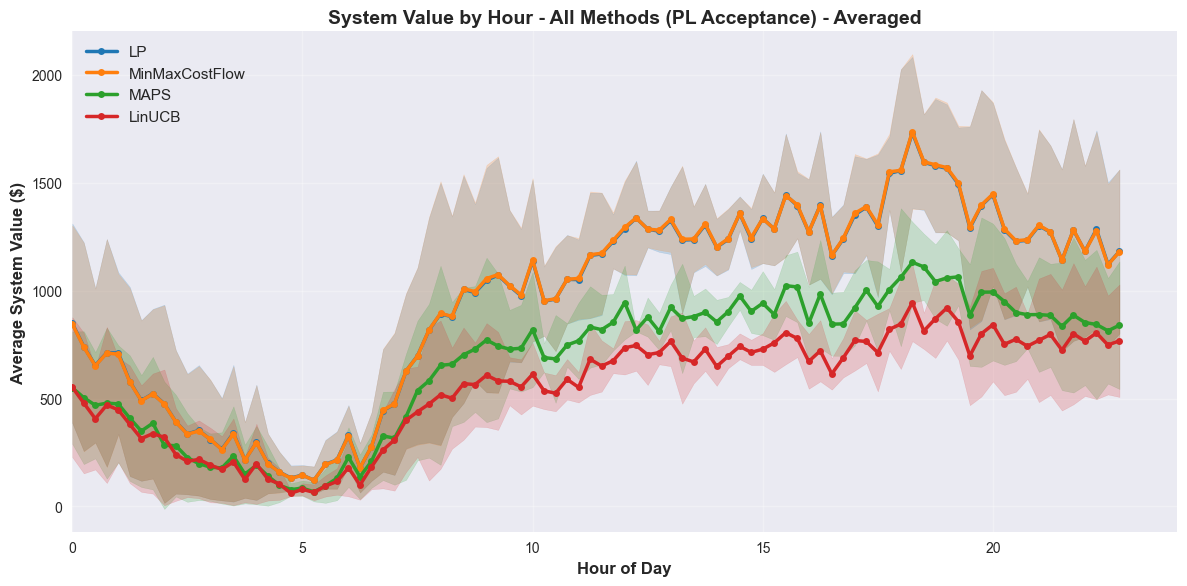

✓ Saved: system_value_all_methods_PL_averaged.png


In [24]:
# Plot 1: System Value - All Methods (PL) - Averaged (Non-cumulative)
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum')
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('System Value by Hour - All Methods (PL Acceptance) - Averaged', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_all_methods_PL_averaged.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_all_methods_PL_averaged.png")


### 1.2 System Value - All Methods (PL) - Cumulative


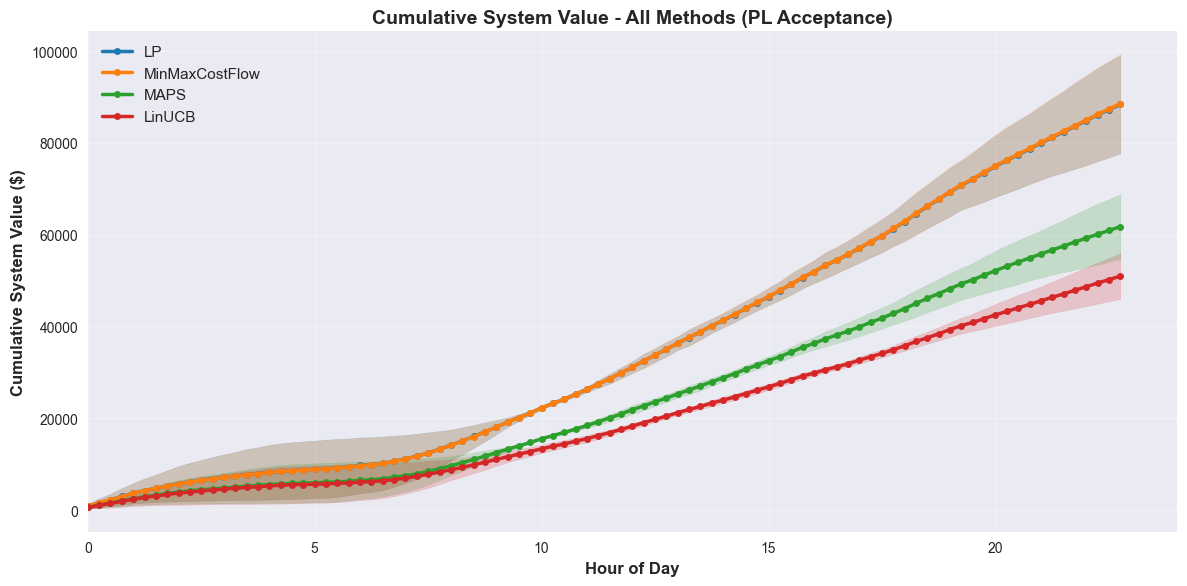

✓ Saved: system_value_all_methods_PL_cumulative.png


In [25]:
# Plot 2: System Value - All Methods (PL) - Cumulative
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum').cumsum()
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative System Value - All Methods (PL Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_all_methods_PL_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_all_methods_PL_cumulative.png")


### 1.3 System Value - All Methods (Sigmoid) - Averaged


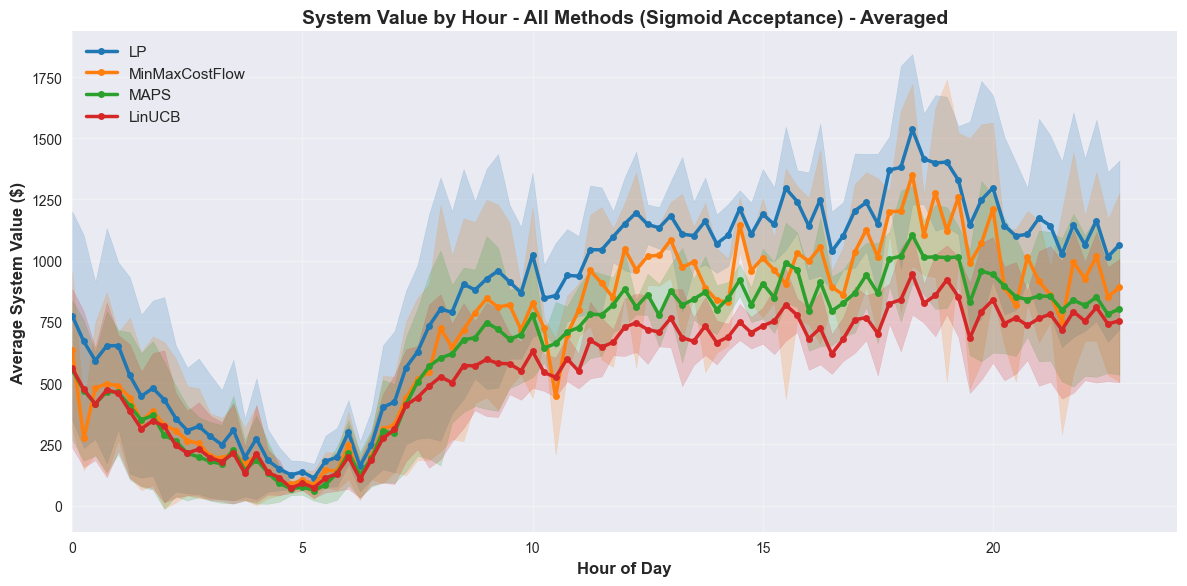

✓ Saved: system_value_all_methods_Sigmoid_averaged.png


In [26]:
# Plot 3: System Value - All Methods (Sigmoid) - Averaged
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum')
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('System Value by Hour - All Methods (Sigmoid Acceptance) - Averaged', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_all_methods_Sigmoid_averaged.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_all_methods_Sigmoid_averaged.png")


### 1.4 System Value - All Methods (Sigmoid) - Cumulative


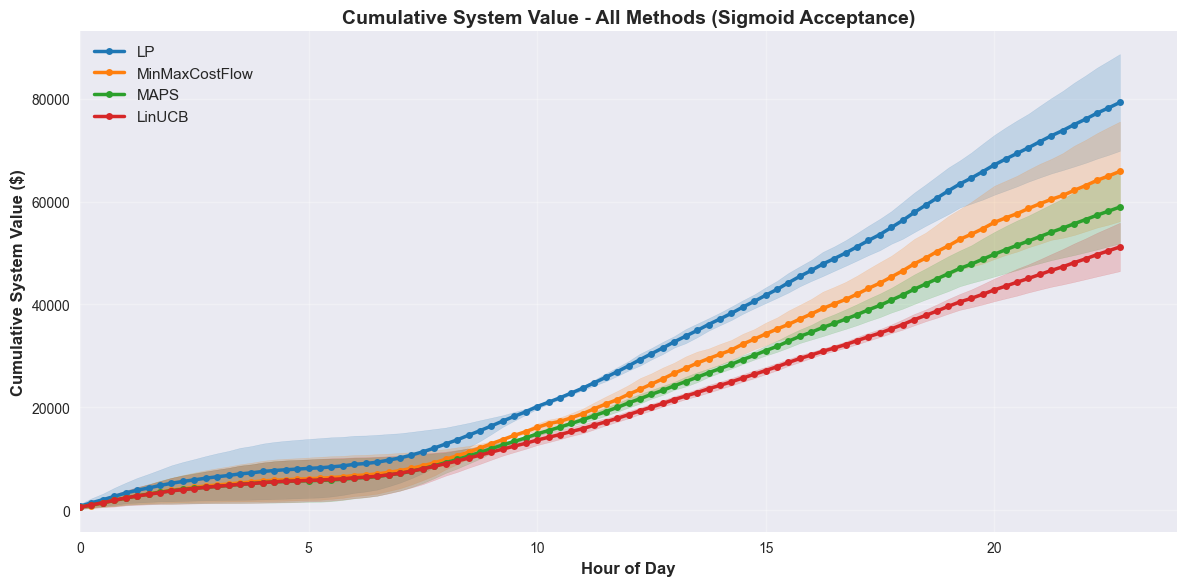

✓ Saved: system_value_all_methods_Sigmoid_cumulative.png


In [27]:
# Plot 4: System Value - All Methods (Sigmoid) - Cumulative
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum').cumsum()
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative System Value - All Methods (Sigmoid Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_all_methods_Sigmoid_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_all_methods_Sigmoid_cumulative.png")


## 2. System Value Plots - LP, MinMaxCostFlow, and LP_OPT

### 2.1 System Value - LP vs MinMaxCostFlow (PL) - Averaged with Optimal


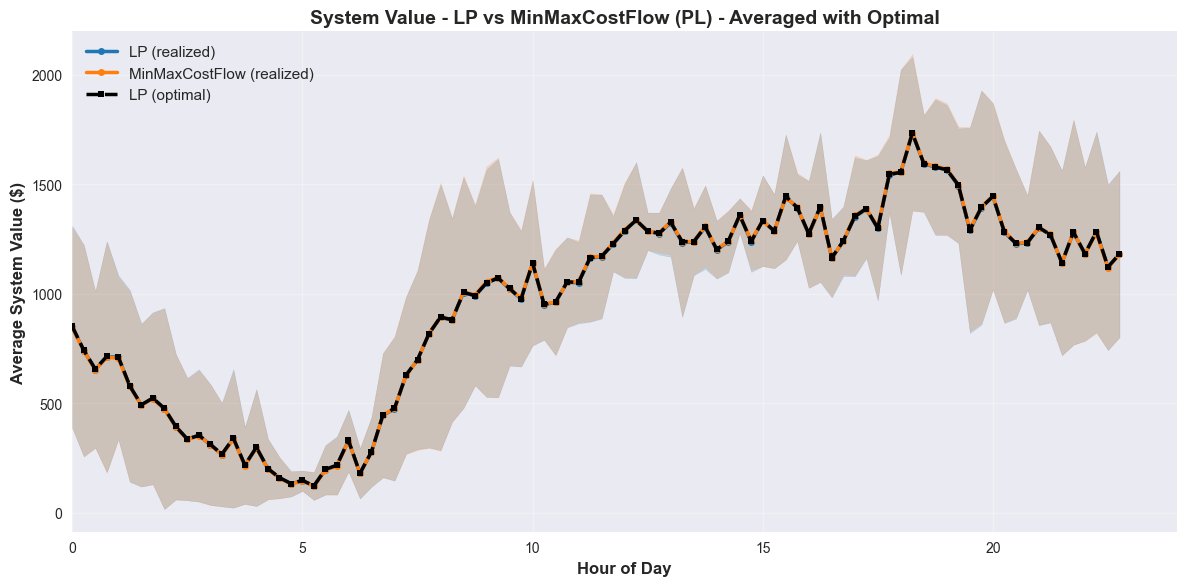

✓ Saved: system_value_LP_vs_MinMax_PL_averaged.png


In [28]:
# Plot 5: System Value - LP vs MinMaxCostFlow (PL) - Averaged with Optimal
fig, ax = plt.subplots(figsize=(12, 6))

for method in ['LP', 'MinMaxCostFlow']:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum')
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=f'{method} (realized)', marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

# LP Optimal
opt_series_list = []
for exp_id, df in decisions.items():
    filtered = filter_data(df, 'LP', 'PL')
    if not filtered.empty:
        hourly = aggregate_by_hour(filtered, 'opt_value', 'sum')
        opt_series_list.append(hourly)

if opt_series_list:
    mean_opt, std_opt = align_and_average(opt_series_list)
    ax.plot(mean_opt.index, mean_opt.values, '--', color='black', 
            linewidth=2.5, label='LP (optimal)', marker='s', markersize=4)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('System Value - LP vs MinMaxCostFlow (PL) - Averaged with Optimal', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_LP_vs_MinMax_PL_averaged.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_LP_vs_MinMax_PL_averaged.png")


### 2.2 System Value - LP vs MinMaxCostFlow (PL) - Cumulative


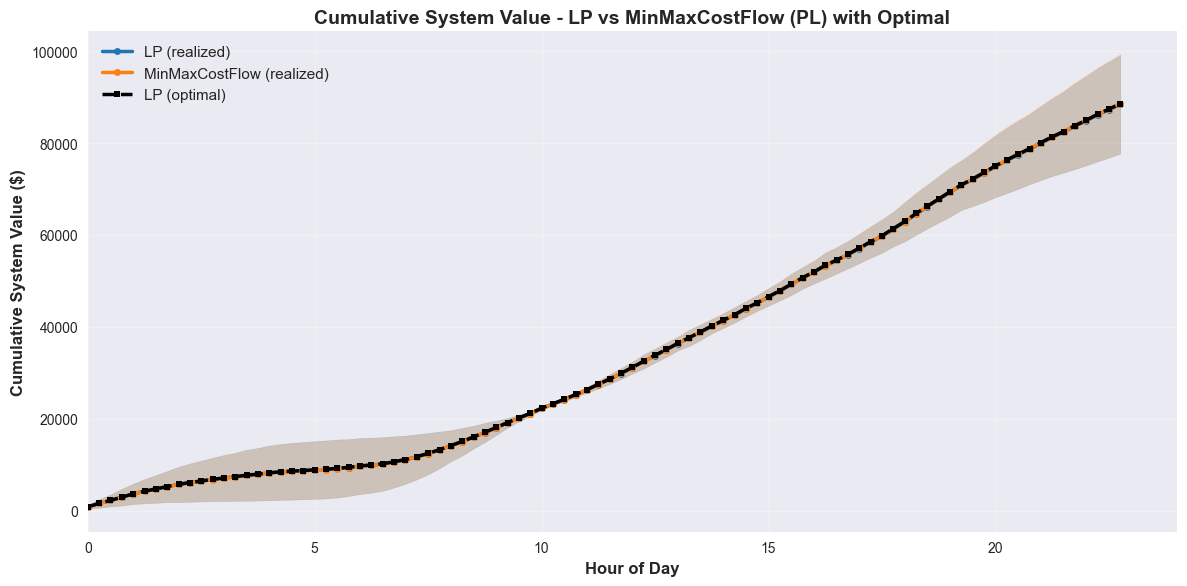

✓ Saved: system_value_LP_vs_MinMax_PL_cumulative.png


In [29]:
# Plot 6: System Value - LP vs MinMaxCostFlow (PL) - Cumulative
fig, ax = plt.subplots(figsize=(12, 6))

for method in ['LP', 'MinMaxCostFlow']:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum').cumsum()
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=f'{method} (realized)', marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

# LP Optimal
opt_series_list = []
for exp_id, df in decisions.items():
    filtered = filter_data(df, 'LP', 'PL')
    if not filtered.empty:
        hourly = aggregate_by_hour(filtered, 'opt_value', 'sum').cumsum()
        opt_series_list.append(hourly)

if opt_series_list:
    mean_opt, std_opt = align_and_average(opt_series_list)
    ax.plot(mean_opt.index, mean_opt.values, '--', color='black', 
            linewidth=2.5, label='LP (optimal)', marker='s', markersize=4)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative System Value - LP vs MinMaxCostFlow (PL) with Optimal', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_LP_vs_MinMax_PL_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_LP_vs_MinMax_PL_cumulative.png")


### 2.3 System Value - LP vs MinMaxCostFlow (Sigmoid) - Averaged


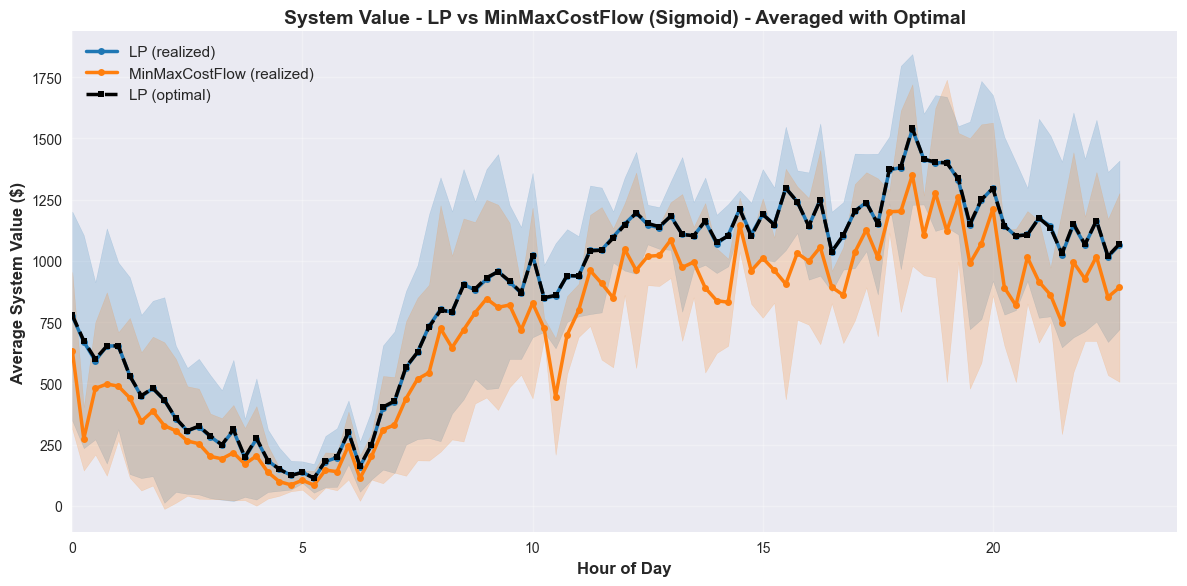

✓ Saved: system_value_LP_vs_MinMax_Sigmoid_averaged.png


In [30]:
# Plot 7: System Value - LP vs MinMaxCostFlow (Sigmoid) - Averaged
fig, ax = plt.subplots(figsize=(12, 6))

for method in ['LP', 'MinMaxCostFlow']:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum')
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=f'{method} (realized)', marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

# LP Optimal
opt_series_list = []
for exp_id, df in decisions.items():
    filtered = filter_data(df, 'LP', 'Sigmoid')
    if not filtered.empty:
        hourly = aggregate_by_hour(filtered, 'opt_value', 'sum')
        opt_series_list.append(hourly)

if opt_series_list:
    mean_opt, std_opt = align_and_average(opt_series_list)
    ax.plot(mean_opt.index, mean_opt.values, '--', color='black', 
            linewidth=2.5, label='LP (optimal)', marker='s', markersize=4)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Average System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('System Value - LP vs MinMaxCostFlow (Sigmoid) - Averaged with Optimal', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_LP_vs_MinMax_Sigmoid_averaged.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_LP_vs_MinMax_Sigmoid_averaged.png")


### 2.4 System Value - LP vs MinMaxCostFlow (Sigmoid) - Cumulative


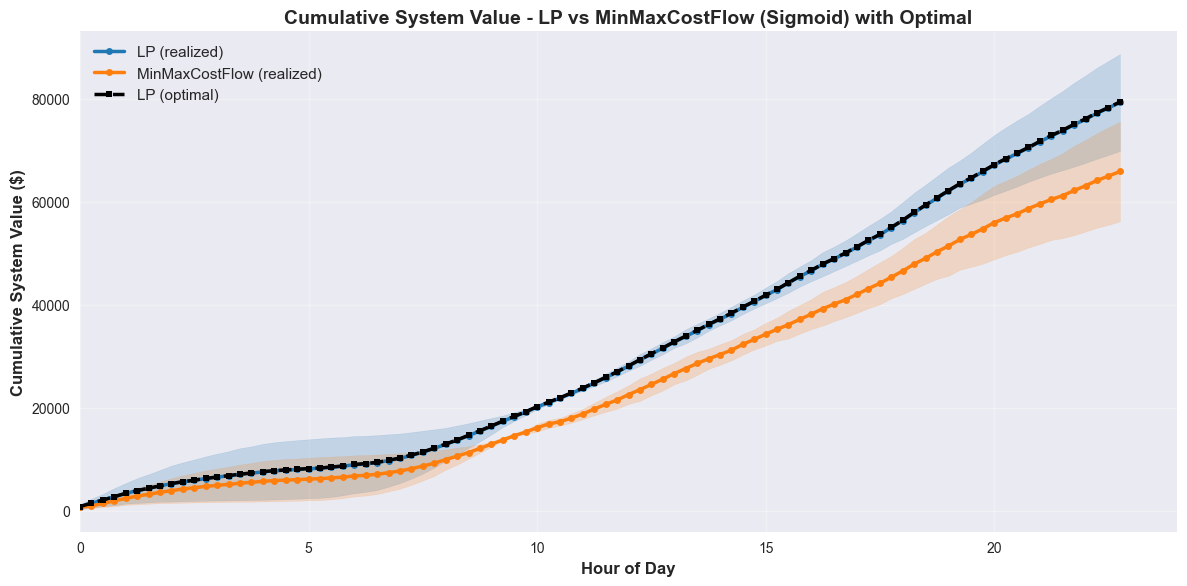

✓ Saved: system_value_LP_vs_MinMax_Sigmoid_cumulative.png


In [31]:
# Plot 8: System Value - LP vs MinMaxCostFlow (Sigmoid) - Cumulative
fig, ax = plt.subplots(figsize=(12, 6))

for method in ['LP', 'MinMaxCostFlow']:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = aggregate_by_hour(filtered, 'expected_total_value', 'sum').cumsum()
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=f'{method} (realized)', marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

# LP Optimal
opt_series_list = []
for exp_id, df in decisions.items():
    filtered = filter_data(df, 'LP', 'Sigmoid')
    if not filtered.empty:
        hourly = aggregate_by_hour(filtered, 'opt_value', 'sum').cumsum()
        opt_series_list.append(hourly)

if opt_series_list:
    mean_opt, std_opt = align_and_average(opt_series_list)
    ax.plot(mean_opt.index, mean_opt.values, '--', color='black', 
            linewidth=2.5, label='LP (optimal)', marker='s', markersize=4)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative System Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative System Value - LP vs MinMaxCostFlow (Sigmoid) with Optimal', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'system_value_LP_vs_MinMax_Sigmoid_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: system_value_LP_vs_MinMax_Sigmoid_cumulative.png")


## 3. Acceptance Rate Plots

### 3.1 Acceptance Rate - All Methods (PL)


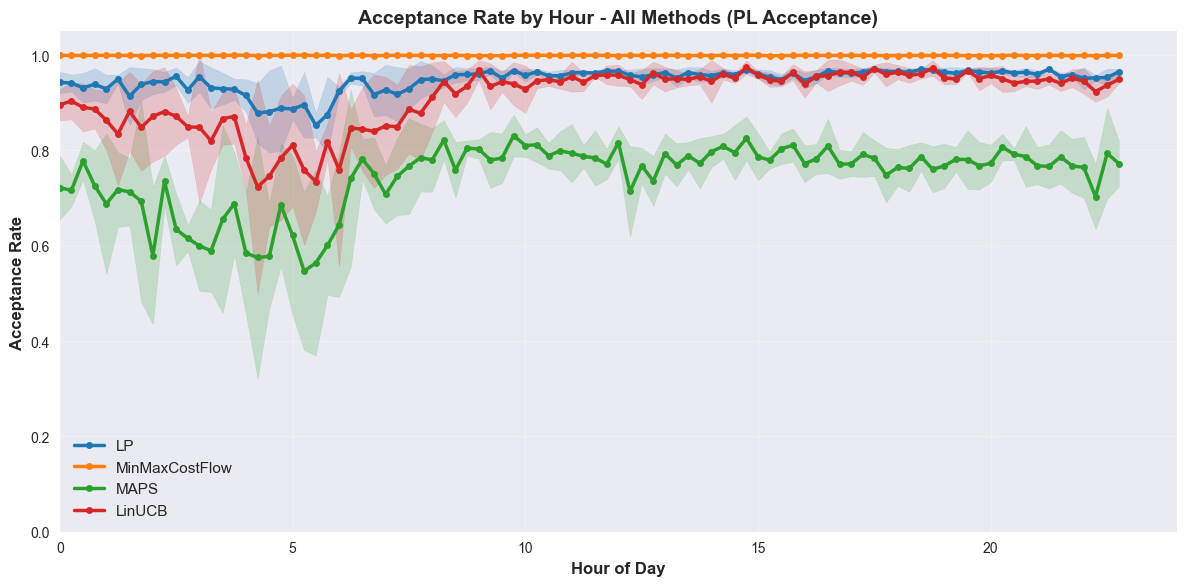

✓ Saved: acceptance_rate_all_methods_PL.png


In [32]:
# Plot 9: Acceptance Rate - All Methods (PL)
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = compute_acceptance_rate(filtered)
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Acceptance Rate', fontsize=12, fontweight='bold')
ax.set_title('Acceptance Rate by Hour - All Methods (PL Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'acceptance_rate_all_methods_PL.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: acceptance_rate_all_methods_PL.png")


### 3.2 Acceptance Rate - All Methods (Sigmoid)


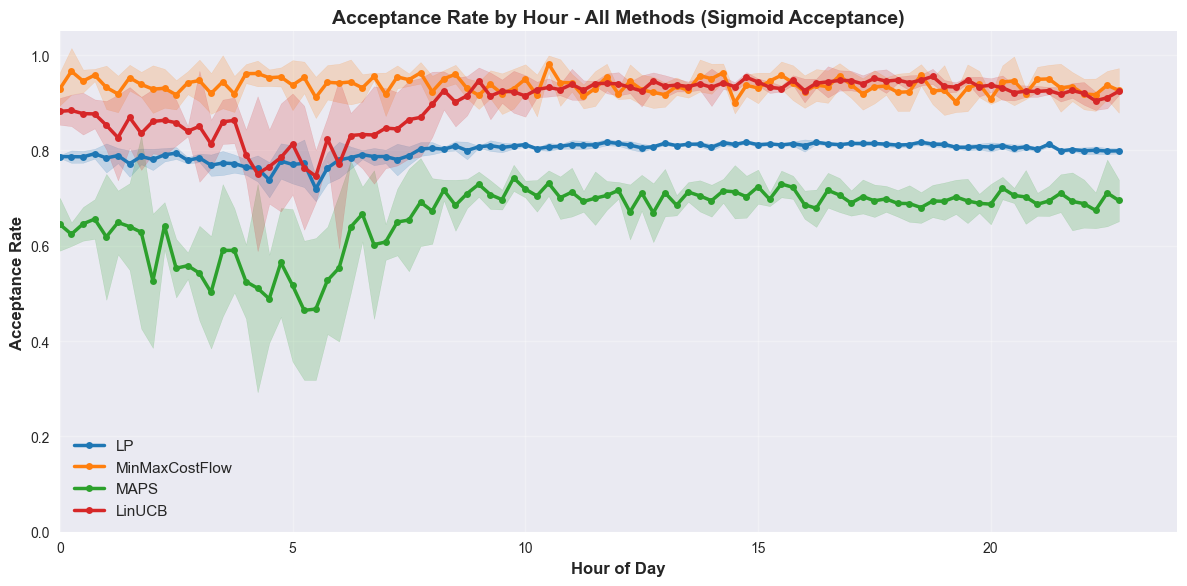

✓ Saved: acceptance_rate_all_methods_Sigmoid.png


In [33]:
# Plot 10: Acceptance Rate - All Methods (Sigmoid)
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = compute_acceptance_rate(filtered)
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Acceptance Rate', fontsize=12, fontweight='bold')
ax.set_title('Acceptance Rate by Hour - All Methods (Sigmoid Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'acceptance_rate_all_methods_Sigmoid.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: acceptance_rate_all_methods_Sigmoid.png")


## 4. Matching Ratio Plots

### 4.1 Matching Ratio - All Methods (PL)


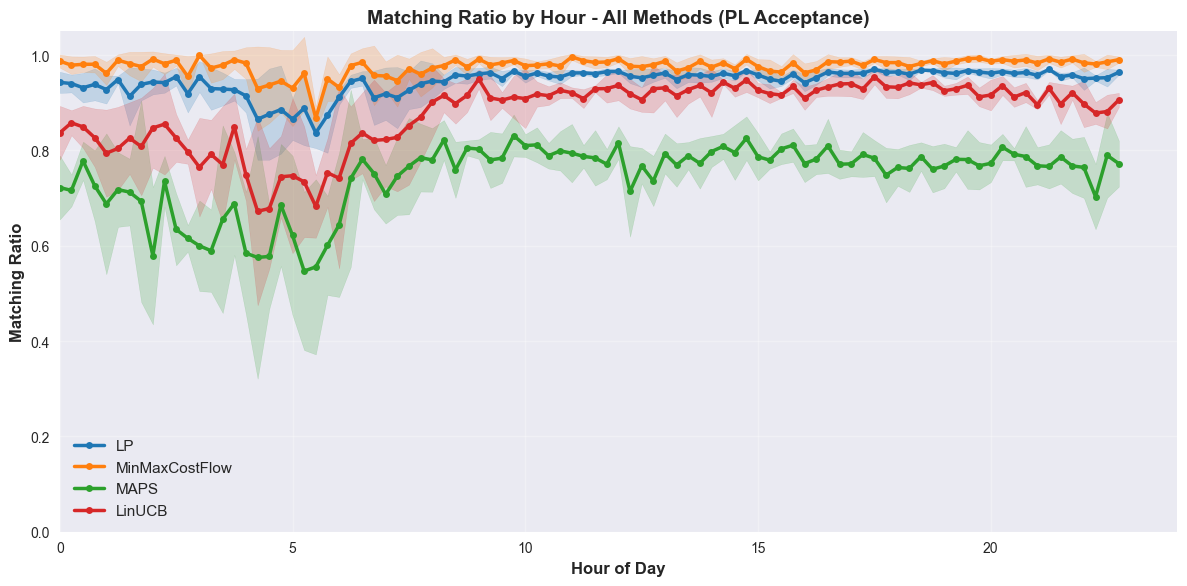

✓ Saved: matching_ratio_all_methods_PL.png


In [34]:
# Plot 11: Matching Ratio - All Methods (PL)
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'PL')
        if not filtered.empty:
            hourly = compute_matching_ratio(filtered)
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Matching Ratio', fontsize=12, fontweight='bold')
ax.set_title('Matching Ratio by Hour - All Methods (PL Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'matching_ratio_all_methods_PL.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: matching_ratio_all_methods_PL.png")


### 4.2 Matching Ratio - All Methods (Sigmoid)


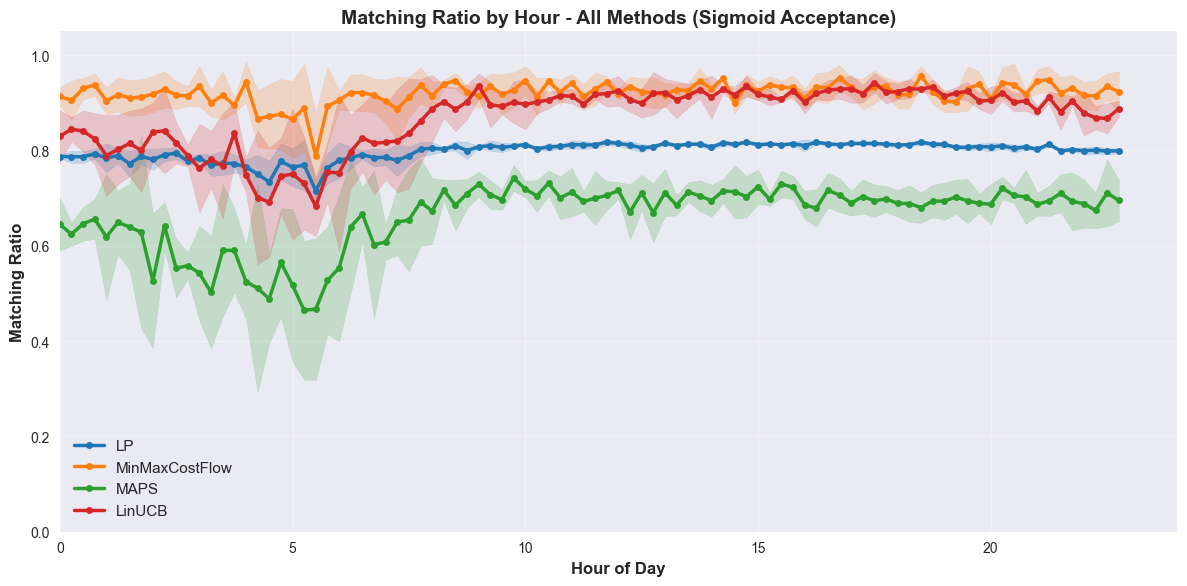

✓ Saved: matching_ratio_all_methods_Sigmoid.png


In [35]:
# Plot 12: Matching Ratio - All Methods (Sigmoid)
fig, ax = plt.subplots(figsize=(12, 6))

for method in METHODS:
    series_list = []
    for exp_id, df in decisions.items():
        filtered = filter_data(df, method, 'Sigmoid')
        if not filtered.empty:
            hourly = compute_matching_ratio(filtered)
            series_list.append(hourly)
    
    if series_list:
        mean, std = align_and_average(series_list)
        ax.plot(mean.index, mean.values, color=METHOD_COLORS[method], 
                linewidth=2.5, label=method, marker='o', markersize=5)
        ax.fill_between(mean.index, mean - std, mean + std, 
                       color=METHOD_COLORS[method], alpha=0.2)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Matching Ratio', fontsize=12, fontweight='bold')
ax.set_title('Matching Ratio by Hour - All Methods (Sigmoid Acceptance)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'matching_ratio_all_methods_Sigmoid.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: matching_ratio_all_methods_Sigmoid.png")


## 5. Summary Tables

### 5.1 Generate Performance Table from Summaries


In [36]:
# Create comprehensive performance table from summaries
table_data = []

for exp_id in EXPERIMENT_IDS:
    summary = summaries.get(exp_id)
    if not summary or 'results_basic_analysis' not in summary:
        continue
    
    date = extract_date_from_exp_id(exp_id)
    perf_by_acceptance = summary['results_basic_analysis'].get('methods_performance_by_acceptance', {})
    
    for method in METHODS:
        for acc_fn in ACCEPTANCE_FUNCTIONS:
            key = f"{method}_{acc_fn}"
            if key in perf_by_acceptance:
                data = perf_by_acceptance[key]
                obj_vals = data.get('objective_values', {})
                acc_rates = data.get('acceptance_rates', {})
                opt_metrics = data.get('optimality_metrics', {})
                
                table_data.append({
                    'Date': date,
                    'Method': method,
                    'Acceptance': acc_fn,
                    'Total_Value': obj_vals.get('sum', 0),
                    'Mean_Value': obj_vals.get('mean', 0),
                    'Std_Value': obj_vals.get('std', 0),
                    'Acceptance_Rate': acc_rates.get('mean', 0),
                    'Optimality_Ratio': opt_metrics.get('optimality_ratio', 0),
                    'Optimality_Gap': opt_metrics.get('optimality_gap', 0),
                })

df_table = pd.DataFrame(table_data)

# Save full table
df_table.to_csv(TABLES_DIR / 'performance_summary.csv', index=False)
print("✓ Saved: performance_summary.csv")
print("\nPerformance Summary:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print(df_table.to_string(index=False))


✓ Saved: performance_summary.csv

Performance Summary:
    Date         Method Acceptance   Total_Value  Mean_Value  Std_Value  Acceptance_Rate  Optimality_Ratio  Optimality_Gap
20191006             LP         PL  75893.982617  824.934594 380.980084         0.944518          0.998107        1.564535
20191006             LP    Sigmoid  68411.643998  743.604826 338.950183         0.798393          0.999951        0.036438
20191006 MinMaxCostFlow         PL  75886.399749  824.852171 381.551084         0.999538          0.998007        1.646958
20191006 MinMaxCostFlow    Sigmoid  55052.125860  598.392672 307.750586         0.935561          0.804679      145.248591
20191006           MAPS         PL  53165.689295  577.887927 266.624923         0.751187          0.699200      248.611202
20191006           MAPS    Sigmoid  50502.974476  548.945375 253.189413         0.663091          0.738186      194.695889
20191006         LinUCB         PL  44905.635508  488.104734 217.514814         0.90

### 5.2 Pivot Tables - Total Value by Method and Date


In [37]:
# Pivot tables for Total Value
if not df_table.empty:
    for acc_fn in ACCEPTANCE_FUNCTIONS:
        subset = df_table[df_table['Acceptance'] == acc_fn]
        pivot = subset.pivot(index='Date', columns='Method', values='Total_Value')
        pivot['Average'] = pivot.mean(axis=1)
        pivot.loc['Average'] = pivot.mean(axis=0)
        
        print("\n" + "="*80)
        print(f"Total Value by Method and Date ({acc_fn} Acceptance)")
        print("="*80)
        print(pivot.to_string())
        
        filename = f'total_value_by_date_{acc_fn}.txt'
        with open(TABLES_DIR / filename, 'w') as f:
            f.write(f"Total Value by Method and Date ({acc_fn} Acceptance)\n")
            f.write("="*80 + "\n")
            f.write(pivot.to_string())
        print(f"\n✓ Saved: {filename}")



Total Value by Method and Date (PL Acceptance)
Method               LP        LinUCB          MAPS  MinMaxCostFlow       Average
Date                                                                             
20191006   75893.982617  44905.635508  53165.689295    75886.399749  62462.926792
20191008   89865.527395  50598.835769  62141.482917    90005.825225  73152.917826
20191010  101854.970233  57014.718055  70518.993578   102065.038939  82863.430201
20191012   86077.170821  51362.279853  61174.609663    86208.557935  71205.654568
Average    88422.912767  50970.367296  61750.193863    88541.455462  72421.232347

✓ Saved: total_value_by_date_PL.txt

Total Value by Method and Date (Sigmoid Acceptance)
Method              LP        LinUCB          MAPS  MinMaxCostFlow       Average
Date                                                                            
20191006  68411.643998  45346.556400  50502.974476    55052.125860  54828.325184
20191008  80356.101047  50964.614861  59370.8

### 5.3 Pivot Tables - Acceptance Rate by Method and Date


In [38]:
# Pivot tables for Acceptance Rate
if not df_table.empty:
    for acc_fn in ACCEPTANCE_FUNCTIONS:
        subset = df_table[df_table['Acceptance'] == acc_fn]
        pivot = subset.pivot(index='Date', columns='Method', values='Acceptance_Rate')
        pivot['Average'] = pivot.mean(axis=1)
        pivot.loc['Average'] = pivot.mean(axis=0)
        
        print("\n" + "="*80)
        print(f"Acceptance Rate by Method and Date ({acc_fn} Acceptance)")
        print("="*80)
        print(pivot.to_string())
        
        filename = f'acceptance_rate_by_date_{acc_fn}.txt'
        with open(TABLES_DIR / filename, 'w') as f:
            f.write(f"Acceptance Rate by Method and Date ({acc_fn} Acceptance)\n")
            f.write("="*80 + "\n")
            f.write(pivot.to_string())
        print(f"\n✓ Saved: {filename}")



Acceptance Rate by Method and Date (PL Acceptance)
Method          LP    LinUCB      MAPS  MinMaxCostFlow   Average
Date                                                            
20191006  0.944518  0.903537  0.751187        0.999538  0.899695
20191008  0.951746  0.908338  0.726312        0.999470  0.896466
20191010  0.949754  0.925206  0.747404        0.999425  0.905447
20191012  0.944999  0.907394  0.753418        0.999322  0.901283
Average   0.947754  0.911119  0.744580        0.999439  0.900723

✓ Saved: acceptance_rate_by_date_PL.txt

Acceptance Rate by Method and Date (Sigmoid Acceptance)
Method          LP    LinUCB      MAPS  MinMaxCostFlow   Average
Date                                                            
20191006  0.798393  0.888210  0.663091        0.935561  0.821314
20191008  0.798320  0.898668  0.648955        0.936752  0.820674
20191010  0.802355  0.912527  0.667086        0.934537  0.829126
20191012  0.795870  0.891937  0.665568        0.939940  0.823329
Avera

### 5.4 Optimality Metrics Table (LP only)


In [39]:
# Optimality metrics for LP
if not df_table.empty:
    lp_data = df_table[df_table['Method'] == 'LP'][['Date', 'Acceptance', 'Total_Value', 'Optimality_Ratio', 'Optimality_Gap']].copy()
    
    print("\n" + "="*80)
    print("LP Optimality Metrics")
    print("="*80)
    print(lp_data.to_string(index=False))
    
    lp_data.to_csv(TABLES_DIR / 'LP_optimality_metrics.csv', index=False)
    print("\n✓ Saved: LP_optimality_metrics.csv")



LP Optimality Metrics
    Date Acceptance   Total_Value  Optimality_Ratio  Optimality_Gap
20191006         PL  75893.982617          0.998107        1.564535
20191006    Sigmoid  68411.643998          0.999951        0.036438
20191008         PL  89865.527395          0.998600        1.369710
20191008    Sigmoid  80356.101047          0.997986        1.762747
20191010         PL 101854.970233          0.998807        1.322287
20191010    Sigmoid  91171.098283          0.999353        0.641384
20191012         PL  86077.170821          0.998395        1.503930
20191012    Sigmoid  77133.297937          0.998103        1.593578

✓ Saved: LP_optimality_metrics.csv


## 6. Summary Statistics


In [40]:
# Print summary statistics
print("\n" + "="*80)
print("OVERALL SUMMARY STATISTICS")
print("="*80)

if not df_table.empty:
    for acc_fn in ACCEPTANCE_FUNCTIONS:
        print(f"\n{acc_fn} Acceptance Function:")
        print("-" * 40)
        subset = df_table[df_table['Acceptance'] == acc_fn]
        
        for method in METHODS:
            method_data = subset[subset['Method'] == method]
            if not method_data.empty:
                avg_value = method_data['Total_Value'].mean()
                avg_acc_rate = method_data['Acceptance_Rate'].mean()
                avg_opt_ratio = method_data['Optimality_Ratio'].mean()
                
                print(f"  {method:15s}: Avg Value=${avg_value:>10,.0f}  "
                      f"AccRate={avg_acc_rate:.3f}  OptRatio={avg_opt_ratio:.3f}")

print("\n" + "="*80)
print("Analysis complete! All plots saved to:", PLOTS_DIR.absolute())
print("All tables saved to:", TABLES_DIR.absolute())
print("="*80)
print(f"\nGenerated {len(list(PLOTS_DIR.glob('*.png')))} plots")
print(f"Generated {len(list(TABLES_DIR.glob('*.csv')) + list(TABLES_DIR.glob('*.txt')))} tables")



OVERALL SUMMARY STATISTICS

PL Acceptance Function:
----------------------------------------
  LP             : Avg Value=$    88,423  AccRate=0.948  OptRatio=0.998
  MinMaxCostFlow : Avg Value=$    88,541  AccRate=0.999  OptRatio=1.000
  MAPS           : Avg Value=$    61,750  AccRate=0.745  OptRatio=0.698
  LinUCB         : Avg Value=$    50,970  AccRate=0.911  OptRatio=0.577

Sigmoid Acceptance Function:
----------------------------------------
  LP             : Avg Value=$    79,268  AccRate=0.799  OptRatio=0.999
  MinMaxCostFlow : Avg Value=$    65,864  AccRate=0.937  OptRatio=0.828
  MAPS           : Avg Value=$    58,935  AccRate=0.661  OptRatio=0.743
  LinUCB         : Avg Value=$    51,177  AccRate=0.898  OptRatio=0.646

Analysis complete! All plots saved to: /Users/borker/mgr/taxibenchmark/plots_final
All tables saved to: /Users/borker/mgr/taxibenchmark/tables_final

Generated 12 plots
Generated 6 tables
